##  Machine Learning - Midterm Project 

Course code : CMPE-257 
Group name : Seekers

Members :

   * Anuradha Rajashekar(012409956)
   * Ashwini Shankar Narayan(012506910)
   * Nidhi Jamar(010070593)
   * Sindhu Goudru Shivanandappa Patil(010823683)
   
### 1. Business case and value
The data in the dataset is from a real Czech bank from 1999. The data is about clients and their accounts and has relations account, client, disposiiton, permanent order, transaction, loan, credit card and demographic data. The Relation 'loan' and 'credit card' describe some services which bank offers to its clients. More credit cards can be issued to an account but atmost one loan can be granted for an account.

The business objective is to analyze the transactional behavior of the customers and predict the loan approval status for the same customers.This is useful in cases where credit card companies provide pre-approved loans for customers based on their payment and other factors. Therefore, we can predict customers who pay regulary and who do not.

To acheive this, the below mentioned steps are followed:

1. Data Preparation

2. Clustering

3. Regression

4. Classification

5. Conclusion

### Dataset Selection
Dataset Link : https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions

### 2. Data Narrative

Our dataset consists of the following information:
    
1.  **account.csv** - Account details of the client
        account_id - identification of the account
        district_id - location of the branch
        frequency - frequency of issuance of statements: "POPLATEK MESICNE" stands for monthly issuance "POPLATEK TYDNE" stands for weekly issuance "POPLATEK PO OBRATU" stands for issuance after transaction
        date - date of creating of the account: in the form YYMMDD
    

2.  **client.csv** - personal details of the client
        client_id - client identifier
        birth_number - birthday and sex: the number is in the form YYMMDD for men, the number is in the form YYMM+50DD for women, where YYMMDD is the date of birth
        district_id - address of the client
    
3.  **disp.csv** - Disposition details
        disp_id - record identifier
        client_id - identification of a client
        account_id - identification of an account
        type - type of disposition (owner/user): only owner can issue permanent orders and ask for a loan    

4.  **loan.csv** - Loan details
        loan_id - record identifier
        account_id - identification of the account
        date - date when the loan was granted: in the form YYMMDD
        amount - amount of money
        duration - duration of the loan
        payments - monthly payments
        status - status of paying off the loan: 
            'A' stands for contract finished, no problems, 
            'B' stands for contract finished, loan not payed, 
            'C' stands for running contract, OK so far,
            'D' stands for running contract, client in debt

5.  **trans.csv** - Transaction details of the client
        trans_id - record identifier
        account_id - account the transaction deals with
        date - date of transaction: in the form YYMMDD
        type +/- transaction: "PRIJEM" stands for credit "VYDAJ" stands for withdrawal
        operation - mode of transaction: "VYBER KARTOU" credit card withdrawal "VKLAD" credit in cash "PREVOD Z UCTU" collection from another bank "VYBER" withdrawal in cash "PREVOD NA UCET" remittance to another bank
        amount - amount of money
        balance - balance after transaction
        k_symbol - characterization of the transaction: "POJISTNE" insurance payment "SLUZBY" payment for statement "UROK" interest credited "SANKC. UROK" sanction interest if negative balance "SIPO" household "DUCHOD" old-age pension "UVER" loan payment
        bank - bank of the partner: each bank has unique two-letter code
        account - account of the partner

 ### 3. Data Preparation
In data preparation step, we read and preprocess the data to identify and remove invlaid values such as ? or NA. Here, we read and parse all the csv files in the dataset using the pandas dataframe.Pandas provide a unique advantage over other libraries in preprocessing the data by providing inbuilt APIs for all the math operations on selected row/column or full dataset. If there are any invalid values, fill it with the median value of the column.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydotplus
import collections
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Image

# Read the original CSV files using Pandas
trans_d = pd.read_csv("data/trans.csv")
loan_d = pd.read_csv("data/loan.csv")
account_d = pd.read_csv("data/account.csv")
client_d = pd.read_csv("data/client.csv")
disp_d = pd.read_csv("data/disp.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Collect the data from multiple CSVs to merge together for an account_id. The loan dataset contains only loan details with accountid. No other information of the client is present in loan dataset. Therefore, we are adding account creation date, account login frequency, date of birth of the client and the district id - location of the branch from account, client, display and transactions dataset to the loan dataset. 

In [4]:
_column_date = []
_column_frequency = []
_column_district = []
_column_clientdob =[]
for c in loan_d['account_id']:
    _result = account_d.loc[account_d['account_id'] == c]
    _column_date.append(_result['date'].iloc[0])
    _column_frequency.append(_result['frequency'].iloc[0])
    _column_district.append(_result['district_id'].iloc[0])
    _result = disp_d.loc[disp_d['account_id'] == c]
    _result = client_d.loc[client_d['client_id'] == _result['client_id'].iloc[0]]
    _column_clientdob.append(_result['birth_number'].iloc[0])

### 4. First Data Enrichment

Adding extra information about account, client, display and transactions to loan dataset

In [5]:
loan_d['account_date'] = _column_date
loan_d['account_loginfrequency'] = _column_frequency
loan_d['account_district'] = _column_district
loan_d['client_birthNumber'] = _column_clientdob

Look for missing data and printing unique value in column 'Status' and 'account_loginfrequency'.
The output shows there are no missing values.

In [6]:
missing = loan_d.isna().sum()
print(missing)

_statusUnique = list(loan_d['status'].unique())
_freqUnique = list(loan_d['account_loginfrequency'].unique())
print('Unique values in status :{}'.format(_statusUnique))
print('Unique values in account login frequency :{}'.format(_freqUnique))

loan_id                   0
account_id                0
date                      0
amount                    0
duration                  0
payments                  0
status                    0
account_date              0
account_loginfrequency    0
account_district          0
client_birthNumber        0
dtype: int64
Unique values in status :['B', 'A', 'C', 'D']
Unique values in account login frequency :['POPLATEK TYDNE', 'POPLATEK MESICNE', 'POPLATEK PO OBRATU']


### Identifying a categorical value in the dataset

Here, the only two features with unique categorical and String values in the datasets is 'status' and 'account_loginfrequency'. Therefore, we need to convert them to integer values. 

From the output, we understand that 'status' feature has 4 unique values: 'A', 'B', 'C' and 'D'. 
 * A stands for contract finished, no problem, 
 * B stands for contract finished, loan not payed, 
 * C stands for running contract, OK so far and 
 * D stands for running contract, client in debt. 

Similarly, from the output, we understand that 'account_loginfrequency'(frequency of issuance of statements) has 3 unique values: 'POPLATEK TYDNE', 'POPLATEK MESICNE', 'POPLATEK PO OBRATU'.
 * "POPLATEK TYDNE" stands for monthly issuance,
 * "POPLATEK TYDNE" stands for weekly issuance and
 * "POPLATEK PO OBRATU" stands for issuance after transaction.
 
Here, we are using index values of these feature tuples to set an integer value. For example, in 'status' feature class B will be assigned an integer value 0.

### Convert String to numerical values
Replace each of the values in status and account_loginfrequency with their corresponding index. Example: Status B will be placed by 0, Status A replaced by 1 and etc.

In [7]:
loan_d['status'] = [_statusUnique.index(item) for item in loan_d['status']] 
loan_d['account_loginfrequency'] = [_freqUnique.index(item) for item in loan_d['account_loginfrequency']] 

### Transform the data in status column to binary

The model is not able to differentiate between clients who have finished the contract and who have not finished contract clearly beacuse there is no column in loan dataset which says whether the contract is finished or not. Therefore, We are reducing the number of classes to binary i.e two classes. This is done by classifying as clients who are paying loan regularly and who are not paying regularly. In other words, transform the data in the status column to binary, by replacing 0 and 3 as 0, 1 and 2 as 1

In [8]:
_temp = []
for d in loan_d['status']:
    if(d==0 or d==3):
        _temp.append(0)
    else:
        _temp.append(1)
loan_d['binary_status']  = _temp  

### 5. Visualizations

#### 5.1 Visualizing Loan amount histogram

This histogram represents the status of Loan amount at that bank. It can be deduced from the graph that more number of people in the bank have taken loan amount for less than 1K. Similarly, we can plot histograms against other features like Payments in the dataset.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(1,0.5,'A stands for contract finished, no problem,\nB stands for contract finished, loan not payed,\nC stands for running contract, OK so far and\nD stands for running contract, client in debt. ')

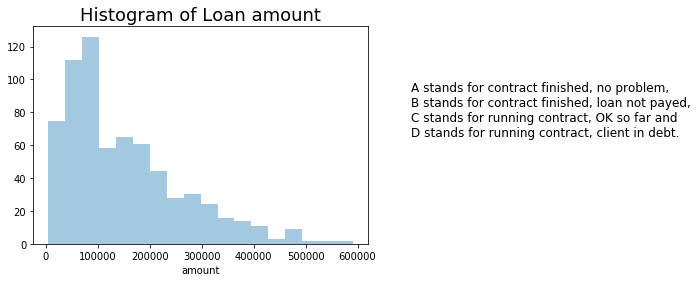

In [9]:
## Plotting a histogram graph with credit history against frequency
figure_text = """A stands for contract finished, no problem,
B stands for contract finished, loan not payed,
C stands for running contract, OK so far and
D stands for running contract, client in debt. """

sns.distplot(loan_d['amount'], kde = False )
plt.title( "Histogram of Loan amount", fontsize = 18)
plt.figtext(1, 0.5,figure_text, wrap=True, horizontalalignment='left', fontsize=12)

#### 5.2 Percentage of loan defaulters vs not defaulters

This pie chart represents the percentage of loan defaulters vs non defaulters.

Percentage of not defaulters = 7.6
Percentage of loan defaulters = 60.6


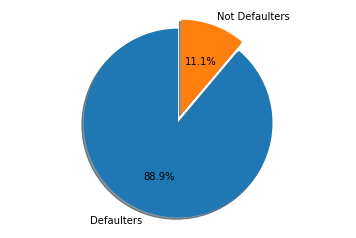

In [10]:
print('Percentage of not defaulters = {}'.format(len(loan_d[loan_d['binary_status']==0])*100/1000))
print('Percentage of loan defaulters = {}'.format(len(loan_d[loan_d['binary_status']==1])*100/1000))

not_defualt = len(loan_d[loan_d['binary_status']==0])*100/1000
defualt = len(loan_d[loan_d['binary_status']==1])*100/1000

labels = 'Defaulters', 'Not Defaulters'
sizes = [defualt,not_defualt]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### 6. Alogrithm Implementation, Interpretation and Metrics

### 6.1 K means
Identify the variance and information content of the dataset.

In [11]:
coll = list(loan_d.columns)
coll.remove("loan_id")
print("Column Name\tMIN\tMAX\tMEDIAN\tInformation Content")

ic = []
for c in coll:
    ic.append(np.var(loan_d[c])/(np.max(loan_d[c])-np.min(loan_d[c])))
ic=ic/np.sum(ic)
i=0
for c in coll:
    print("{}\t{}\t{}\t{}\t{}".format(c,loan_d[c].min(),loan_d[c].max(),loan_d[c].median(),ic[i]))
    i=i+1

Column Name	MIN	MAX	MEDIAN	Information Content
account_id	2	11362	5738.5	0.013968182681812397
date	930705	981208	970206.5	0.06225939033693138
amount	4980	590820	116928.0	0.32290632349330045
duration	12	60	36.0	8.939889416179913e-05
payments	304.0	9910.0	3934.0	0.007522657175862669
status	0	3	2.0	2.1686302508540554e-06
account_date	930113	971222	960126.0	0.07173823665679743
account_loginfrequency	0	2	1.0	1.2739794304050271e-06
account_district	1	77	39.0	0.00012282532010768303
client_birthNumber	350129	806207	581072.5	0.5213880833600024
binary_status	0	1	1.0	1.4594713424969843e-06


#### Identifying number of groups.

In this step, we try to see how many clusters will yeild a better interclass and intra class distance. The ideal solution should minimize the intraclass distance (i.e distance between the group samples to the centroid) and maximize the inter class distance (i.e the distance between the centroids of different groups). This will provide a good enough seperation between clusters. A key factor in measuring this parameter is the WCSS.

*WCSS - (Within Cluster Sum of Squares) Represents the sum of squares distance of all the samples to the centroid of each cluster.


In the graph below, the number of clusters between which the error reduction is not so huge is the perfect candidate.

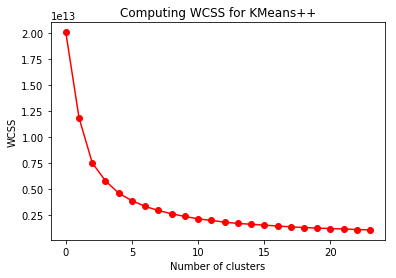

In [12]:
from sklearn.cluster import KMeans # kmeans class for clustering

vals = loan_d.iloc[ :, 1:].values
wcss = []
for ii in range( 1, 25 ):
    kmeans = KMeans(n_clusters=ii, init="k-means++", n_init=10, max_iter=300) 
    kmeans.fit_predict( vals )
    wcss.append( kmeans.inertia_ )
    
plt.plot( wcss, 'ro-', label="WCSS")
plt.title("Computing WCSS for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

From the above graph, 4 clusters seems to be a good value.

Applying K-means clustering
Now that we have decided to group the data into 4 clusters, we use sklearn to perform K-means clustering. Also we can plot the covariance matrix of each feature with other features in the dataset with clusters points represented in hue colors.

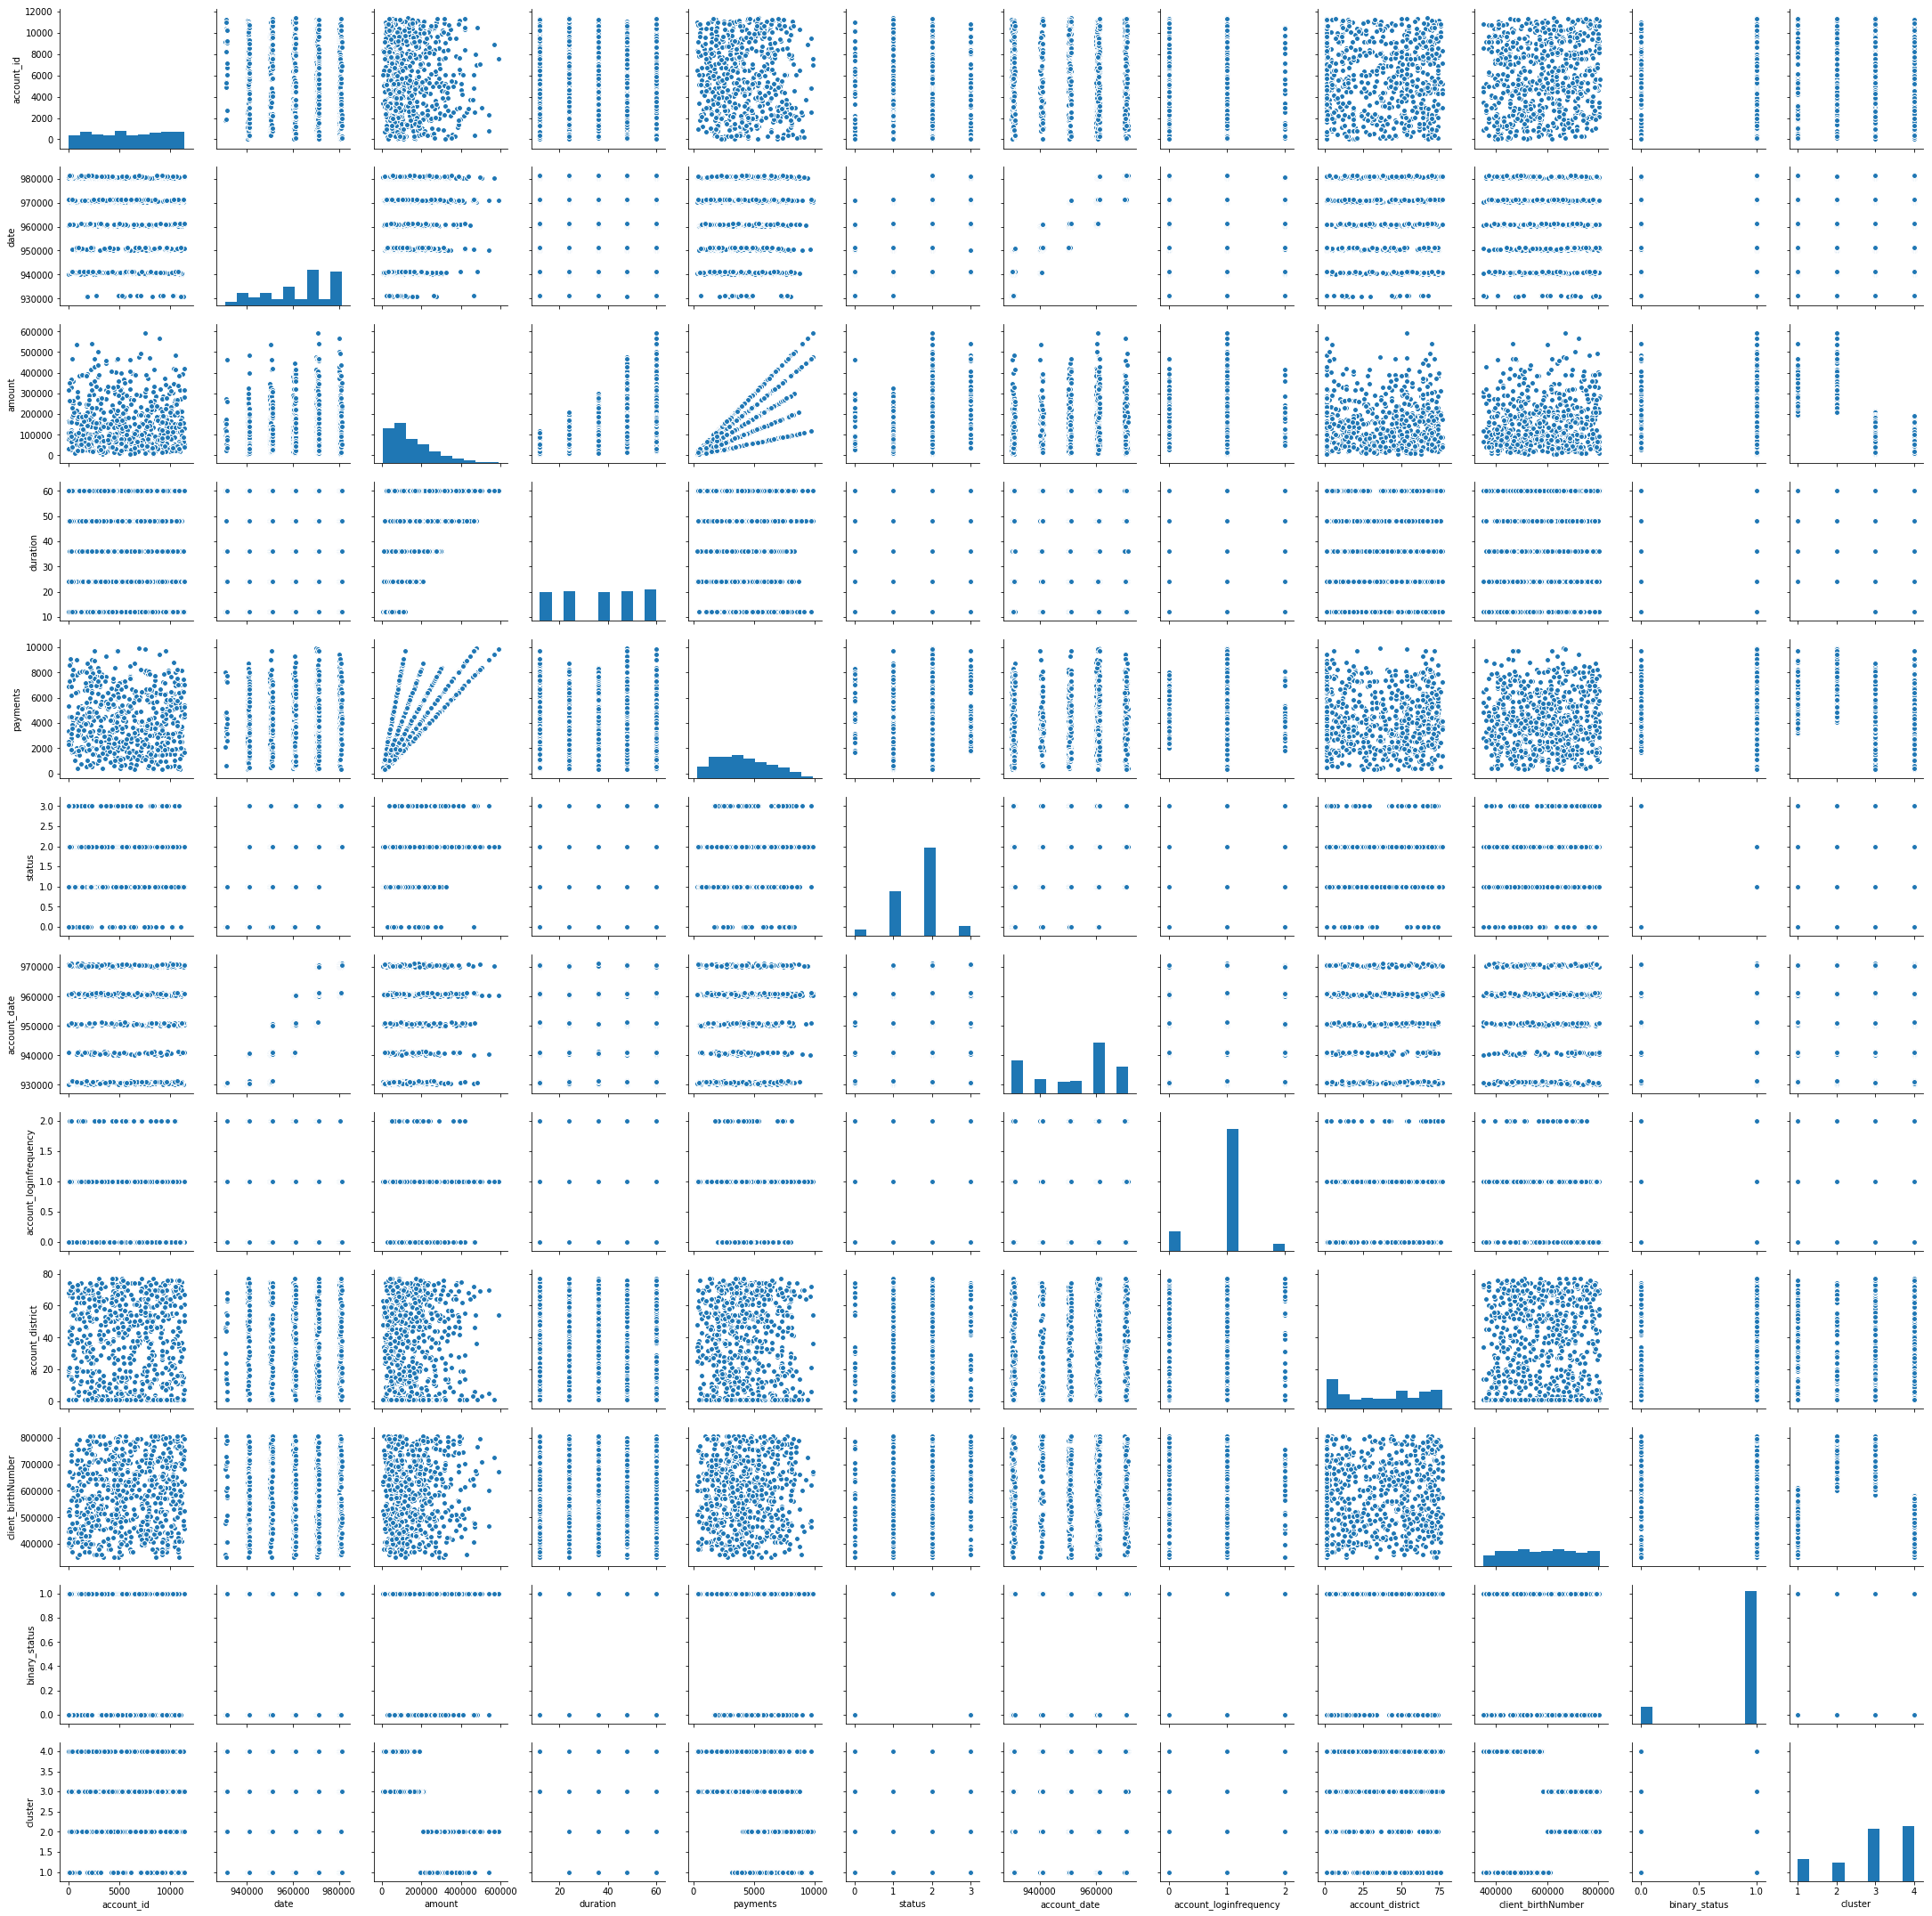

In [13]:
import seaborn as sns # plotting 
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300) 
y_pred = kmeans.fit_predict( vals )

loan_d["cluster"] = 4-y_pred
cols = list(loan_d.columns)
cols.remove("loan_id")

sns.pairplot( loan_d[ cols ])

Analysing the resultant clusters
From the above covariance graph matrix, we can clearly see correspondense between payments and purchases. These features seems to have a major role in clustering customers to different groups. To understand the groups a little better, we can plot only these features.

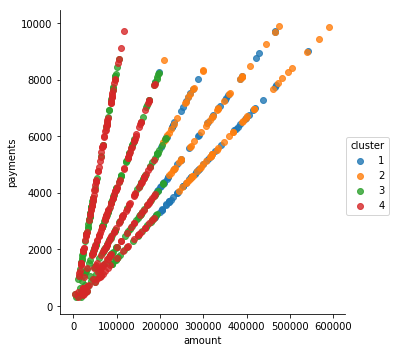

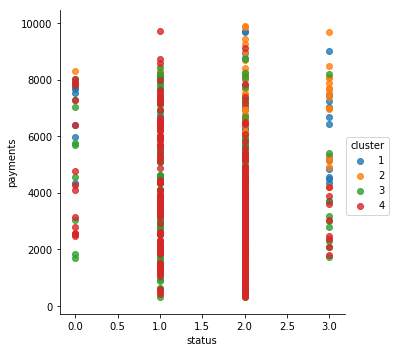

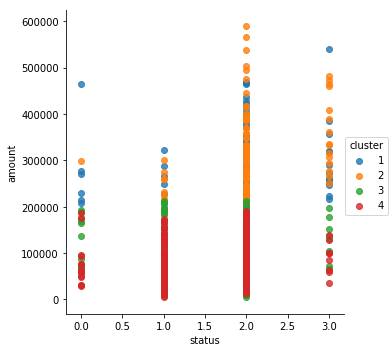

In [14]:
sns.lmplot("amount","payments", data=loan_d, hue='cluster', fit_reg=False)
sns.lmplot("status","payments", data=loan_d, hue='cluster', fit_reg=False)
sns.lmplot("status","amount", data=loan_d, hue='cluster', fit_reg=False)
plt.show()

### 6.1.2 Interpretation

Based on the graph above, we can conclude that the clsutering using K-means heavily relies on the loan amount around 200000 dollars defaulters and all the loans below 200000 dollars are non deafulters. Hence, we can conclude that K-means relies on one particular feature and would not generalize to all the features and would not be a great fit for our business usecase.

### 6.2 Gaussian Mixture Model(GMM)

From K means, we understand that we can cluster data in 4 groups and anything greater than 4 would give us smaller groups and any less would give us groups englufing multiple bigger groups. In both the situations it would be very hard to distinguish the charecteristics of the cluster. In this step we only select the values from the columns listed above and use guassian mixture model to cluster them into groups.

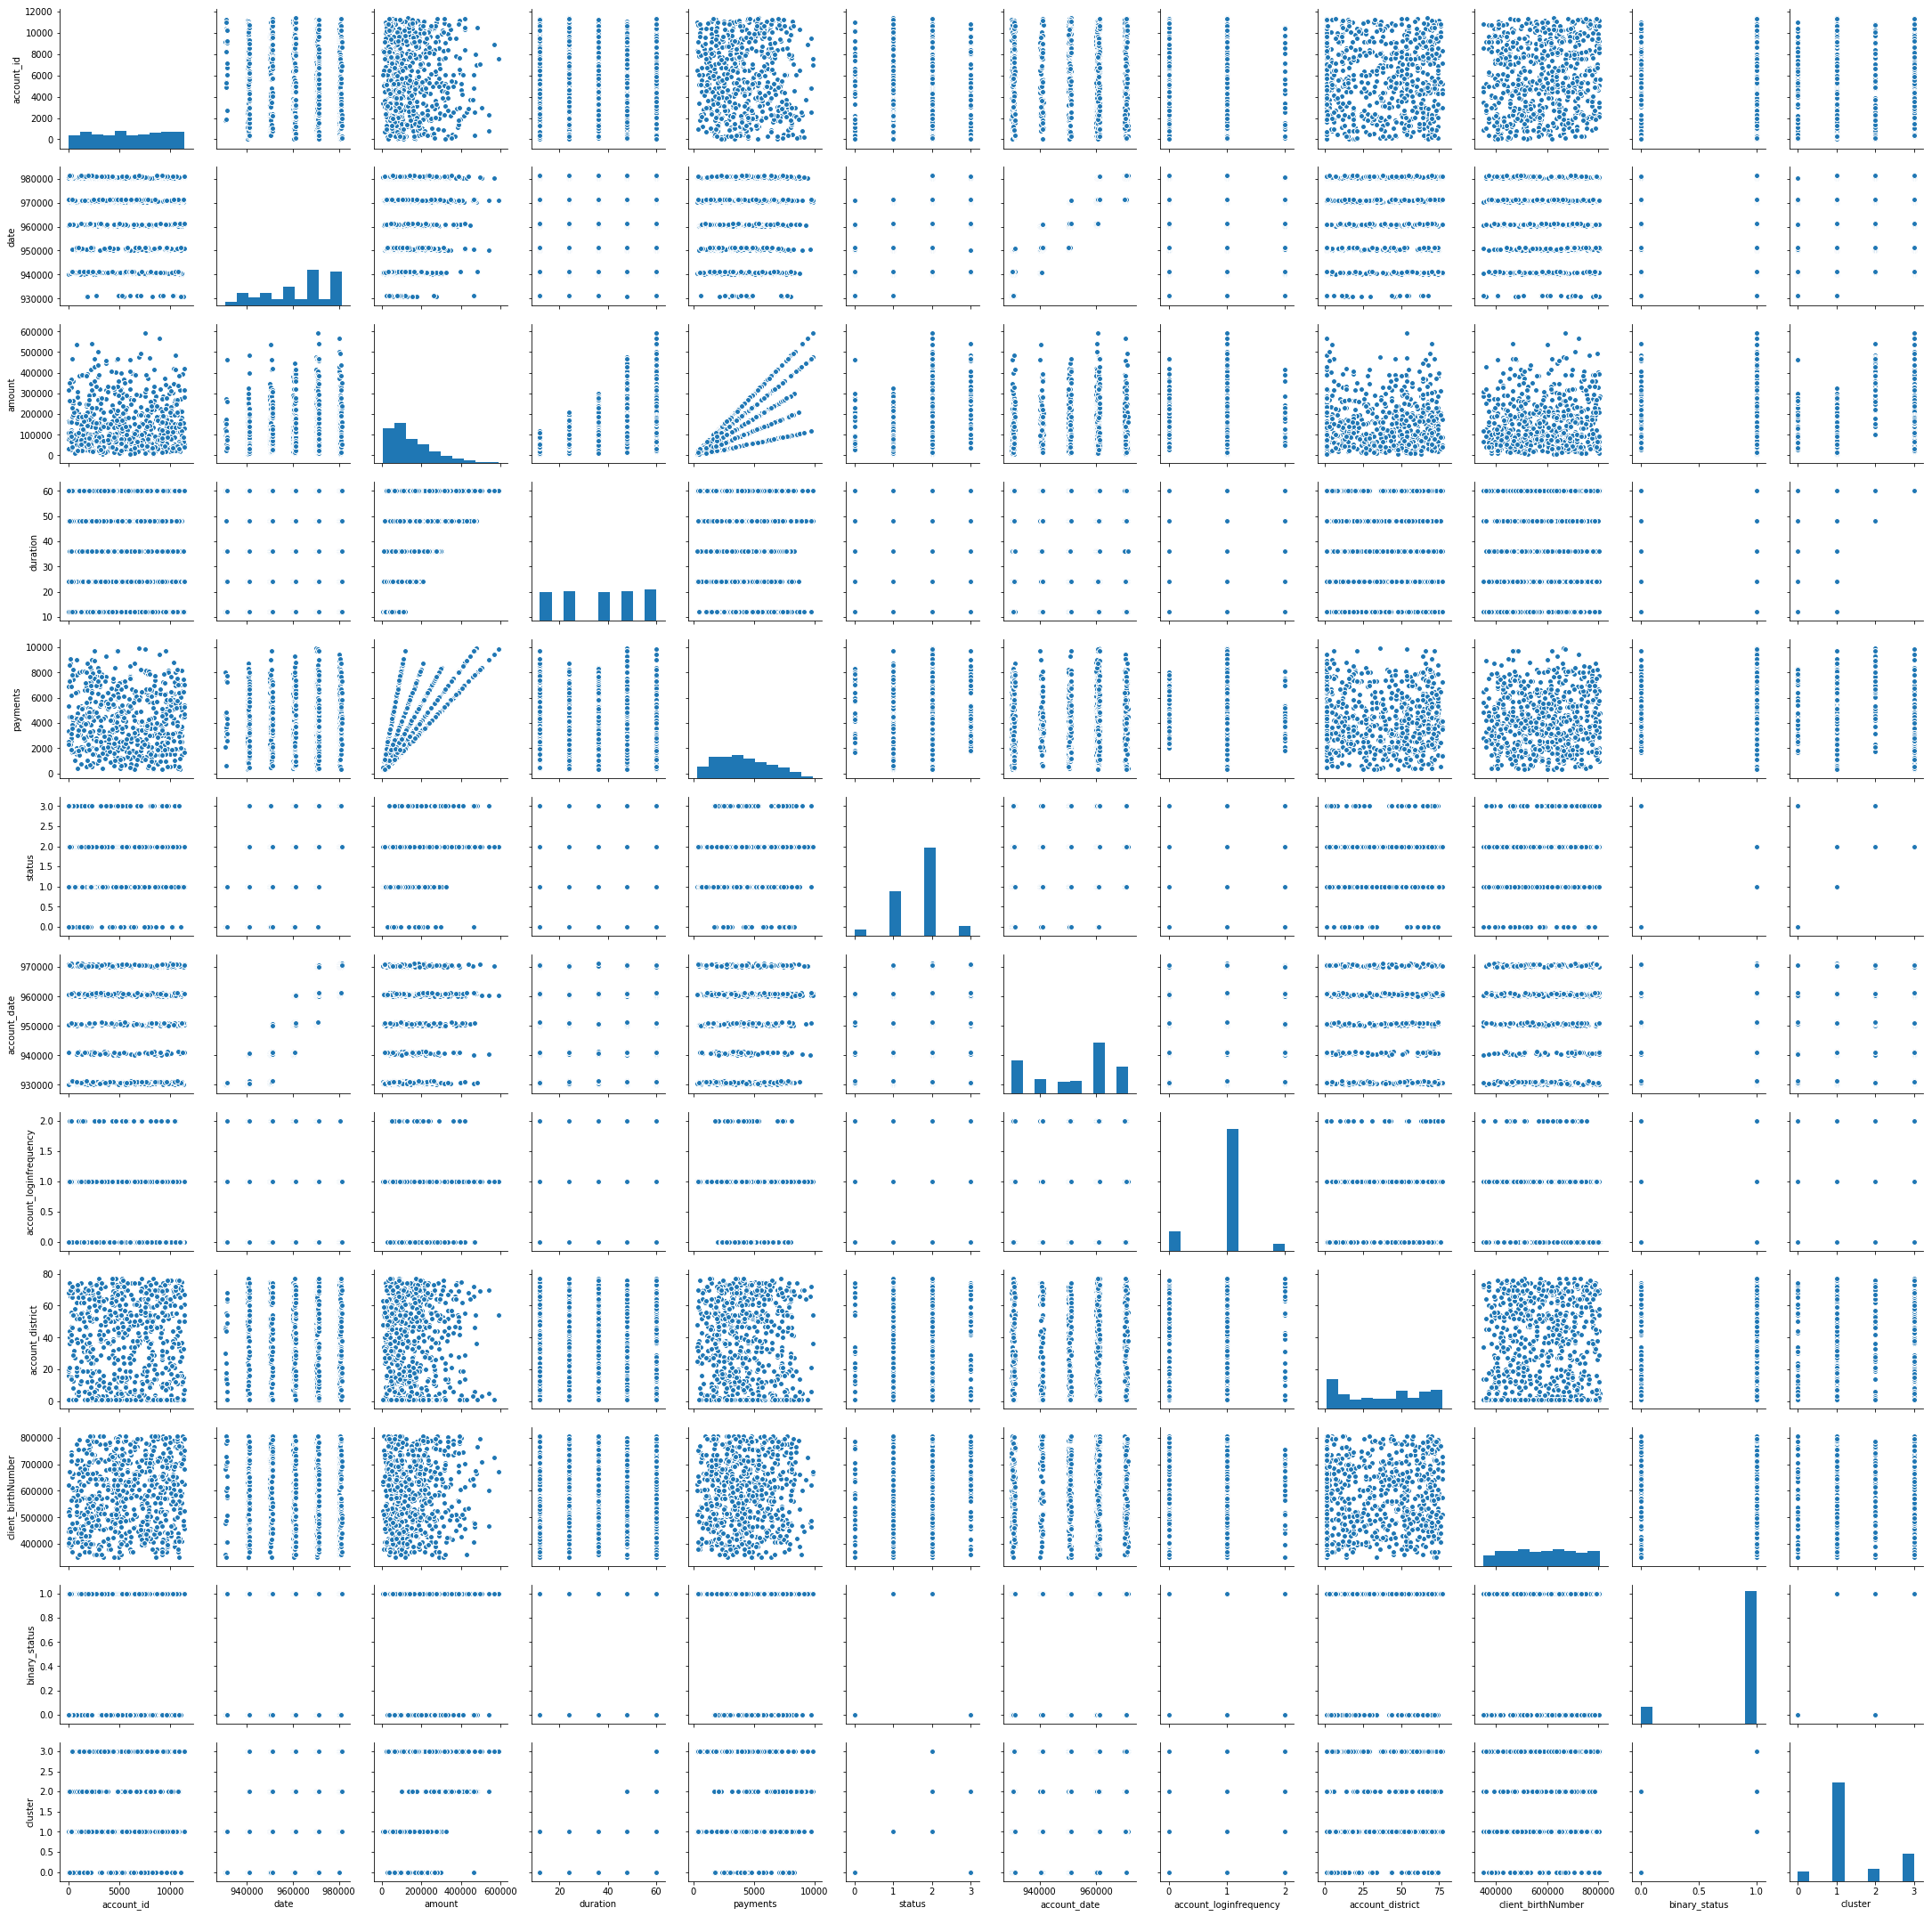

In [15]:
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture # GMM class for clustering
gmm = BayesianGaussianMixture(n_components=4, covariance_type='full').fit(vals)
y_pred = gmm.predict( vals )
loan_d["cluster"] = y_pred
cols = list(loan_d.columns)
cols.remove("loan_id")

sns.pairplot( loan_d[ cols ])

#### 6.2.1 Apply PCA to understand the dataset

In previous step, we made the assumption that our data has only two main dimentions that contribute significatly for any analysis on this dataset, ie. Payments and Purchases. One good way to test this assumption is to plot the data along first two major Principle components.

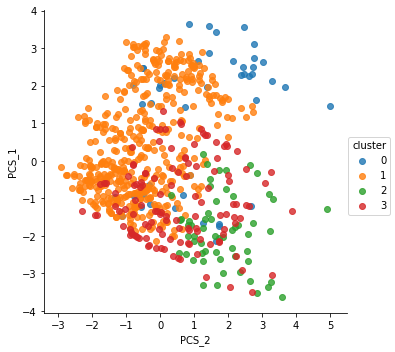

In [16]:
cols = list(loan_d.columns)
cols.remove("loan_id")
cols.remove("cluster")
X = loan_d[cols].iloc[ :, 1:].values
Y = loan_d["cluster"]

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

loan_d["PCS_1"] = Y_sklearn[:,0]
loan_d["PCS_2"] = Y_sklearn[:,1]
sns.lmplot("PCS_2","PCS_1", data=loan_d, hue='cluster',fit_reg=False)

plt.show()

From the graph above, its clear that all 4 groups of our data are clearly spread between the PC1 and PC2 axis. One very intresting point is that the red cluster and the orange cluster are aligned along PCS_2 axis stating that there are closely related. This analysis closely relates to our analysis in the previous assignemnt, that two groups among the clusters made either small payment or only minimum payments. The Other two clusters are aligned towards PCS_1 or inbetween PCS_1(Green) & PCS_2(Blue).

####  Analysing the resultant clusters

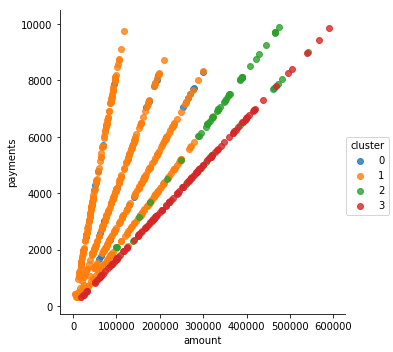

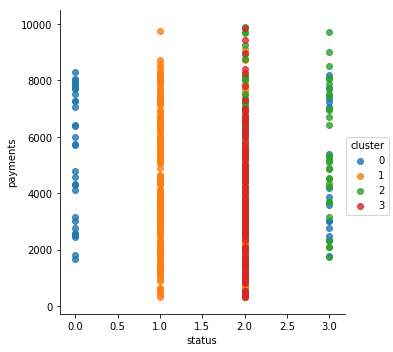

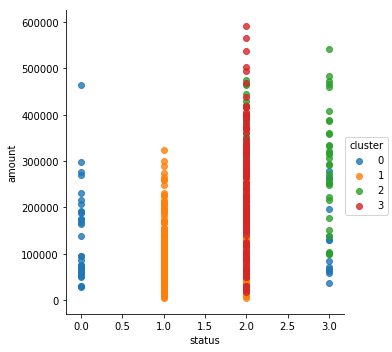

In [17]:
sns.lmplot("amount","payments", data=loan_d, hue='cluster', fit_reg=False)
sns.lmplot("status","payments", data=loan_d, hue='cluster', fit_reg=False)
sns.lmplot("status","amount", data=loan_d, hue='cluster', fit_reg=False)
plt.show()

####  6.2.2  Interpretation
Our usecase/Buissiness dataset is more probablistic and hence a hard clustering approach like K Means will always cluster based on the loan amount and produce more outliers. In such scenarios use of a probablistic model helps us understand the data better by providing probablities for existence in each cluster and thus will help understand the characteristic of each cluster better.  Hence Guassian mixture model gives us a better clustering compared to the K means and better outlier handling. 

As our usecase is full of numbers, frequencies and probablities, a probablistic approach like GMM will provide a better clustering, as it can be seen in the graphs above.

### 6.3 Linear Regression

To perform regression, we need an input and a label. Specifically in our credit card dataset, as we dont have a label, we would try to predict one of our features using Linear regression. For this assignment, we intend to regress on Loan Amount features in our dataset.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
def regressor(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1/3, random_state = 0)

    reg = LinearRegression(normalize=True)
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_test)
    mse = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
    return mse ,[Y_test, Y_pred]

#### Linear Regression on Loan Amount Feature

RMSE:  0.07137070501611446
R2 score:  0.8826699166021642


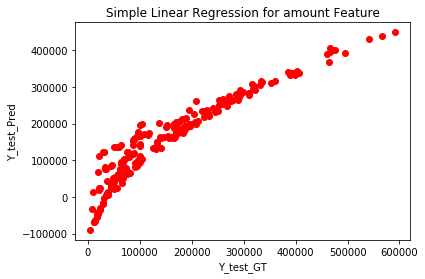

In [19]:
cols = list(loan_d.columns)
cols.remove('loan_id')
cols.remove('account_id')
cols.remove('amount')
cols.remove('cluster')
cols.remove('PCS_1')
cols.remove('PCS_2')
X = loan_d[cols].iloc[ :, 0:].values
Y = loan_d['amount']

error, _Y = regressor(X,Y)
print('RMSE: ', error/max(Y))
print('R2 score: ',metrics.r2_score(_Y[0],_Y[1]))

 # Plotting data
plt.scatter(_Y[0],_Y[1], color = 'red')
plt.title('Simple Linear Regression for amount Feature')
plt.xlabel('Y_test_GT')
plt.ylabel('Y_test_Pred')
plt.show()

### 6.3.1 Second data enrichment

#### Add age feature: Seperating client DOB and gender from Client dataset and calculate Age of the customer based on the Date of Birth

In [20]:
# Seperating client DOB and gender from Client dataset
gender=[]
dob=[]
for t in _column_clientdob:
    _t = [int(d) for d in str(t)]
    if((_t[2]*10+_t[3]-50)>0):
        t=((_t[0]*10+_t[1])*10*10+ (_t[2]*10+_t[3]-50))*10*10 +(_t[4]*10+_t[5])
        gender.append(1)
        dob.append(t)
    else:
        gender.append(0)
        dob.append(t)
loan_d['client_dob'] = dob
loan_d['client_gender'] = gender

# Calculate the age of the customer based on his DOB and current date(Loan approval date)
import datetime
def toage(X,Y):
    if(len(X)==len(Y)):
        to_return=[]
        for i in range(0,len(X)):
            _x = [int(d) for d in str(X[i])]
            _y = [int(d) for d in str(Y[i])]
            x_years = 19*100+_x[0]*10+_x[1]
            x_months = _x[2]*10+_x[3]
            x_date = _x[4]*10+_x[5]
            y_years = 19*100+_y[0]*10+_y[1]
            y_months = _y[2]*10+_y[3]
            y_date = _y[4]*10+_y[5]
            to_return.append((datetime.datetime(x_years, x_months, x_date, 0, 0)-datetime.datetime(y_years, y_months, y_date, 0, 0)).days)
        return to_return
        
    return None

age = toage(loan_d['date'],loan_d['client_dob'])

if age is not None:
    loan_d['client_age'] = age 
    

In [21]:
# enhanced data features 
missing = loan_d.isna().sum()
print(missing)

loan_id                   0
account_id                0
date                      0
amount                    0
duration                  0
payments                  0
status                    0
account_date              0
account_loginfrequency    0
account_district          0
client_birthNumber        0
binary_status             0
cluster                   0
PCS_1                     0
PCS_2                     0
client_dob                0
client_gender             0
client_age                0
dtype: int64


##### Analysing Loan amount feature post data enrichment

RMSE:  0.07088133053383762
R2 score:  0.8842734175289334


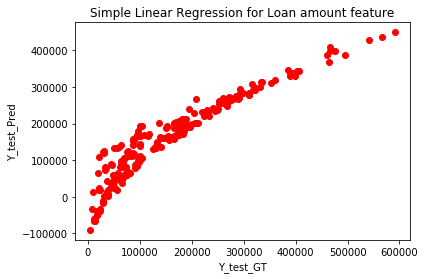

In [22]:
cols = list(loan_d.columns)
cols.remove('loan_id')
cols.remove('account_id')
cols.remove('amount')
cols.remove('cluster')
cols.remove('PCS_1')
cols.remove('PCS_2')
X = loan_d[cols].iloc[ :, 0:].values
Y = loan_d['amount']

error, _Y = regressor(X,Y)
print('RMSE: ' , error/max(Y))
print('R2 score: ',metrics.r2_score(_Y[0],_Y[1]))

# Plotting graph
plt.scatter(_Y[0],_Y[1], color = 'red')
plt.title('Simple Linear Regression for Loan amount feature')
plt.xlabel('Y_test_GT')
plt.ylabel('Y_test_Pred')
plt.show()

### 6.3.2 Latent Variables and Latent Manifold Identification

Based on the information provided in the loan dataset and some addition information, predicting the loan amount or the payments feature was seen above using linear regression. One key information missing about the users loan information, that could help in the background is <b> payment relaibality.</b> The information about his payments like frequency of payments, amoiunt of payments and such information could help model the user. In the foreground we could provide this information to the model and in the backgroud the model should be able to analyse the payment relaibality as its a linear relation ship between duration, payment, apyment frequency, amount of payments and such information.

##### Use the manifold to add features to the dataset and run regression based on those new features.

 Continuing the idea of payment relaibality, we add more information about the consumers transaction over time to the loan by filtering his transaction and calculating his median payment amount, last payment date, number of payents till date and balence as of that day.

In [23]:
_tmpdf = trans_d.loc[trans_d['k_symbol'] == 'UVER']
acc_idlist = list(_tmpdf['account_id'].unique())
averagepayments=[]
balenceasoflastpaymentdate=[]
lastpaymentdate=[]
numberofPayment=[]

for t in acc_idlist:
    _t = _tmpdf.loc[_tmpdf['account_id'] == t]
    numberofPayment.append(len(_t['amount']))
    averagepayments.append(_t['amount'].median())
    balenceasoflastpaymentdate.append((_t['balance'].values)[-1])
    lastpaymentdate.append((_t['date'].values)[-1])

payments_ave=[]
lastpaymtBal=[]
lastpaymtDate=[]
noPayments=[]
pmt_relaibality=[]
for c in loan_d['account_id']:
    idx = acc_idlist.index(c)
    payments_ave.append(averagepayments[idx])
    lastpaymtBal.append(balenceasoflastpaymentdate[idx])
    noPayments.append(numberofPayment[idx])
    lastpaymtDate.append(lastpaymentdate[idx])
    _t = loan_d.loc[loan_d['account_id'] == t]
    if((_t['duration'].values[0]-numberofPayment[idx])>0):
        pmt_relaibality.append(1-((balenceasoflastpaymentdate[idx]/(_t['duration'].values[0]-numberofPayment[idx])))/_t['payments'].values[0])
    else:
        pmt_relaibality.append(1)
    
# Payment reliability features
loan_d['payment_average'] = payments_ave
loan_d['balenceAsOfLastpayment'] = lastpaymtBal
loan_d['lastPaymentDate'] = lastpaymtDate
loan_d['numberofpayments'] = noPayments
# Payment Reliabality
loan_d['paymentReliability'] = pmt_relaibality


cols = list(loan_d.columns)
cols.remove('loan_id')
cols.remove('account_id')
cols.remove('amount')
cols.remove('cluster')
cols.remove('PCS_1')
cols.remove('PCS_2')
X = loan_d[cols].iloc[ :, 0:].values
Y = loan_d['amount']

### 6.3.3 Metrics

In [24]:
print('RMSE: ' , error/max(Y))
print('R2 score: ',metrics.r2_score(_Y[0],_Y[1]))

RMSE:  0.07088133053383762
R2 score:  0.8842734175289334


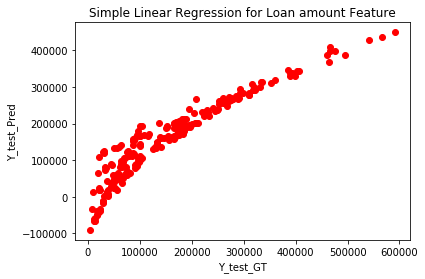

In [25]:
# Plotting graph
plt.scatter(_Y[0],_Y[1], color = 'red')
plt.title('Simple Linear Regression for Loan amount Feature')
plt.xlabel('Y_test_GT')
plt.ylabel('Y_test_Pred')
plt.show()

### 6.3.4 Interpretation

How does this improve the interpretability of your model?
    - In our use case, Linear Regression is trying to predict the loan amount feature against our ground truth loan amount feature and clustering this dataset into multiple groups and understanding the differences between the groups will be the inferencing process. In our model due to data enhancement, has reduced the RMSE error from 0.071852086 to 0.0711152550. Hence, we dont expect the model to reduce any error, but we expect the inferencing to be more robust and will be able to handle more outliers. 
    
How does it add value to your business case?
    - In our usecase, this information will help inferencing differences between clusters and analysing their unique features. This will help us understand the behaviour of customers and to predict their future transactional behaviour as well know how reliable the customer is in terms of providing loans or credit cards.

### 6.4 Logistic Regression

Split the data to 70% training data and 30% test data to train model

In [26]:
from sklearn.model_selection import train_test_split
cols = list(loan_d.columns)
cols.remove('loan_id')
cols.remove('account_id')
cols.remove('status')
cols.remove('binary_status')
cols.remove('cluster')
cols.remove('PCS_1')
cols.remove('PCS_2')
X = loan_d[cols].iloc[ :, 0:].values
Y = loan_d['status']
Y_bin = loan_d['binary_status']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=71)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, Y_bin, test_size=0.3, random_state=12)

LOGISTIC REGRESSION on 'status' feature.

In this step, we are trying to predict the value of 'status' feature by applying Logistic Regression on a random value in test dataset. For the test dataset, after applying logistic regression, the ground truth value and predicted value is 1.

In [27]:
#Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)

logreg_bin = LogisticRegression(C=1e5)
logreg_bin.fit(X_train_bin, y_train_bin)

num = np.random.randint(low=0, high=np.shape(X_test)[0], size=1)[0]
result=logreg.predict(X_test[num,:].reshape(1, -1))[0]
gt= y_test[num]
print('4 class logistic regression   index : ',num,', predicted : ',result,', Ground truth : ',gt)


4 class logistic regression   index :  91 , predicted :  1 , Ground truth :  1


In [32]:
num = np.random.randint(low=0, high=np.shape(X_test_bin)[0], size=1)[0]
result=logreg_bin.predict(X_test_bin[num,:].reshape(1, -1))[0]
gt= y_test_bin[num]
print(' Binary class logistic regression   index : ',num,', predicted : ',result,', Ground truth : ',gt)

 Binary class logistic regression   index :  167 , predicted :  1 , Ground truth :  1


Predicting the accuracy,precision and recall for the column 'status'

After the machine is trained with 70% dataset, we are trying to predict the accuracy of the test data upon appying Logistic Regression. We can observe, for 4 class 'status' feature, the accuracy is 70%. This is beacuse the model was not able to clearly distinguish between clients who belong to classes 'A' and 'C'- who are paying loan regularly and classes 'B' and 'D' - who are not paying loan regulalry.

Print the classification report and confusion matrix.
The classification report consists of precision, recall, f1- score and support.

In [33]:
from sklearn.metrics import classification_report
y_pred = logreg.predict(X_test)
print('Accuracy ', accuracy_score(y_test,y_pred)*100)
print('Metrics for 4 class logistic regression\n',classification_report(y_test, y_pred))

Accuracy  71.21951219512195
Metrics for 4 class logistic regression
              precision    recall  f1-score   support

          0       0.00      0.00      0.00         8
          1       0.65      0.51      0.57        61
          2       0.74      0.89      0.80       125
          3       0.67      0.36      0.47        11

avg / total       0.68      0.71      0.68       205



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 6.4.1 Metrics

In [34]:
from sklearn.metrics import classification_report
y_pred_bin = logreg_bin.predict(X_test_bin)

print('Accuracy ',accuracy_score(y_test_bin,y_pred_bin)*100)
print('Metrics for binary class logistic regression\n',classification_report(y_test_bin, y_pred_bin))


Accuracy  93.65853658536587
Metrics for binary class logistic regression
              precision    recall  f1-score   support

          0       0.50      0.15      0.24        13
          1       0.95      0.99      0.97       192

avg / total       0.92      0.94      0.92       205



#### 6.4.2 Interpretation

After making 'status' feature as binary, the accuracy increased from 70.24% to  93.65%. Precision increased from 63% to 88% and recall increased from 70% to 94%, meaning the model is now able to clearly distinguish between clients paying loan regularly and not paying.

The confusion matrix gives the true positives, true negatives, false positives and false negatives. The confusion matrix of binary class logistic regression has less false positives compared to 4 class logistic regression.

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix of 4 class logistic regression\n',confusion_matrix)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_bin, y_pred_bin)
print('\n\nConfusion matrix of binary class logistic regression\n',confusion_matrix)

Confusion matrix of 4 class logistic regression
 [[  0   1   5   2]
 [  0  31  30   0]
 [  0  14 111   0]
 [  0   2   5   4]]


Confusion matrix of binary class logistic regression
 [[  2  11]
 [  2 190]]


### 6.5 Decision Tree

In [36]:
import pydotplus
import collections
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Image

Function definintion to visualize the decision tree

In [37]:
def gettreeImg(clf,columns):
    dot_data = tree.export_graphviz(clf,
                                    feature_names=columns,
                                    out_file=None,
                                    filled=True,
                                    rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])
    return graph

DECISION TREE on 'status' feature

Applying Decision tree classifier on "status" feature. Training data for multiclass classification. Calculated accuracy of the predicted data(y_test, y_pred)

#### 6.5.1 Metrics

In [38]:
multi_classifier = DecisionTreeClassifier(random_state=0,max_depth=3,criterion='gini')
multi_classifier.fit(X_train,y_train)
y_pred = multi_classifier.predict(X_test)

print('Accuracy',accuracy_score(y_test,y_pred)*100)

Accuracy 92.6829268292683


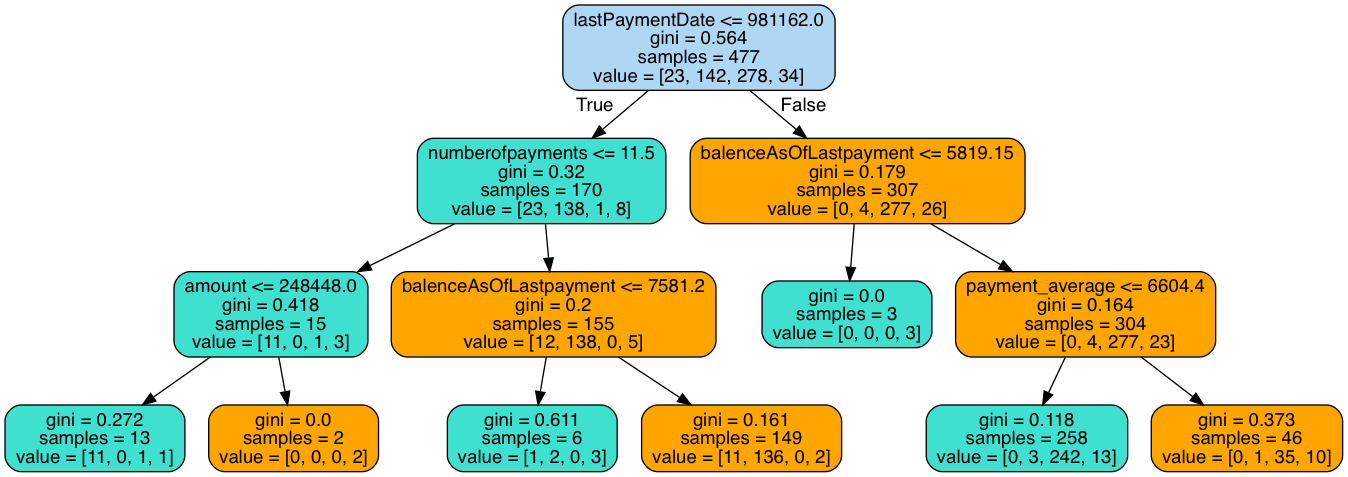

In [39]:
from IPython.display import Image
Image(gettreeImg(multi_classifier,cols).create_png())

#### Defining depth for Decision tree and training data for binary classification

Applying Decision tree classifier on "status" feature. Training data for binary classification.After making 'status' feature as binary, the precision increased from 81.4% to 91.2% meaning the model is now able to clearly distinguish between clients paying loan regularly and not paying.

In [40]:
binary_classifier = DecisionTreeClassifier(random_state=0,max_depth=3)
binary_classifier.fit(X_train_bin,y_train_bin)
y_pred_bin = binary_classifier.predict(X_test_bin)

print('Accuracy',accuracy_score(y_test_bin,y_pred_bin)*100)

Accuracy 94.14634146341463


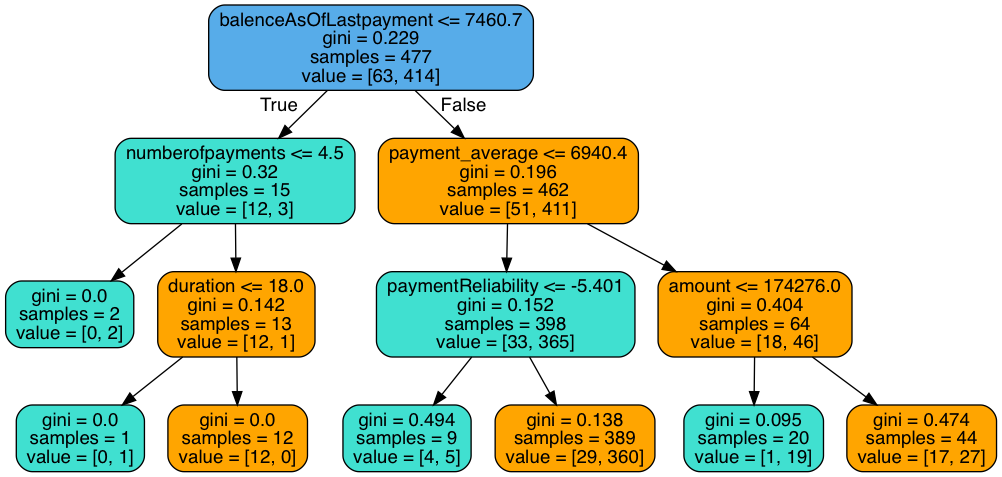

In [41]:
Image(gettreeImg(binary_classifier,cols).create_png())

#### 6.5.2 Interpretation

In the above decision tree, we can infer that multiclass classification has better results comapared to binary classification. Accuracy in Binary classifier is 94% which infers that our model is performing better in Binary classification.

## 6.6 Random Forest

Apply Random Forest on "status" feature. Train the data for multiclass classification. Calculate accuracy of the predicted data(y_test, y_pred)

In [42]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


#### 6.6.1 Metrics

In [43]:
print('Accuracy',accuracy_score(y_test,y_pred)*100)

Accuracy 93.17073170731707


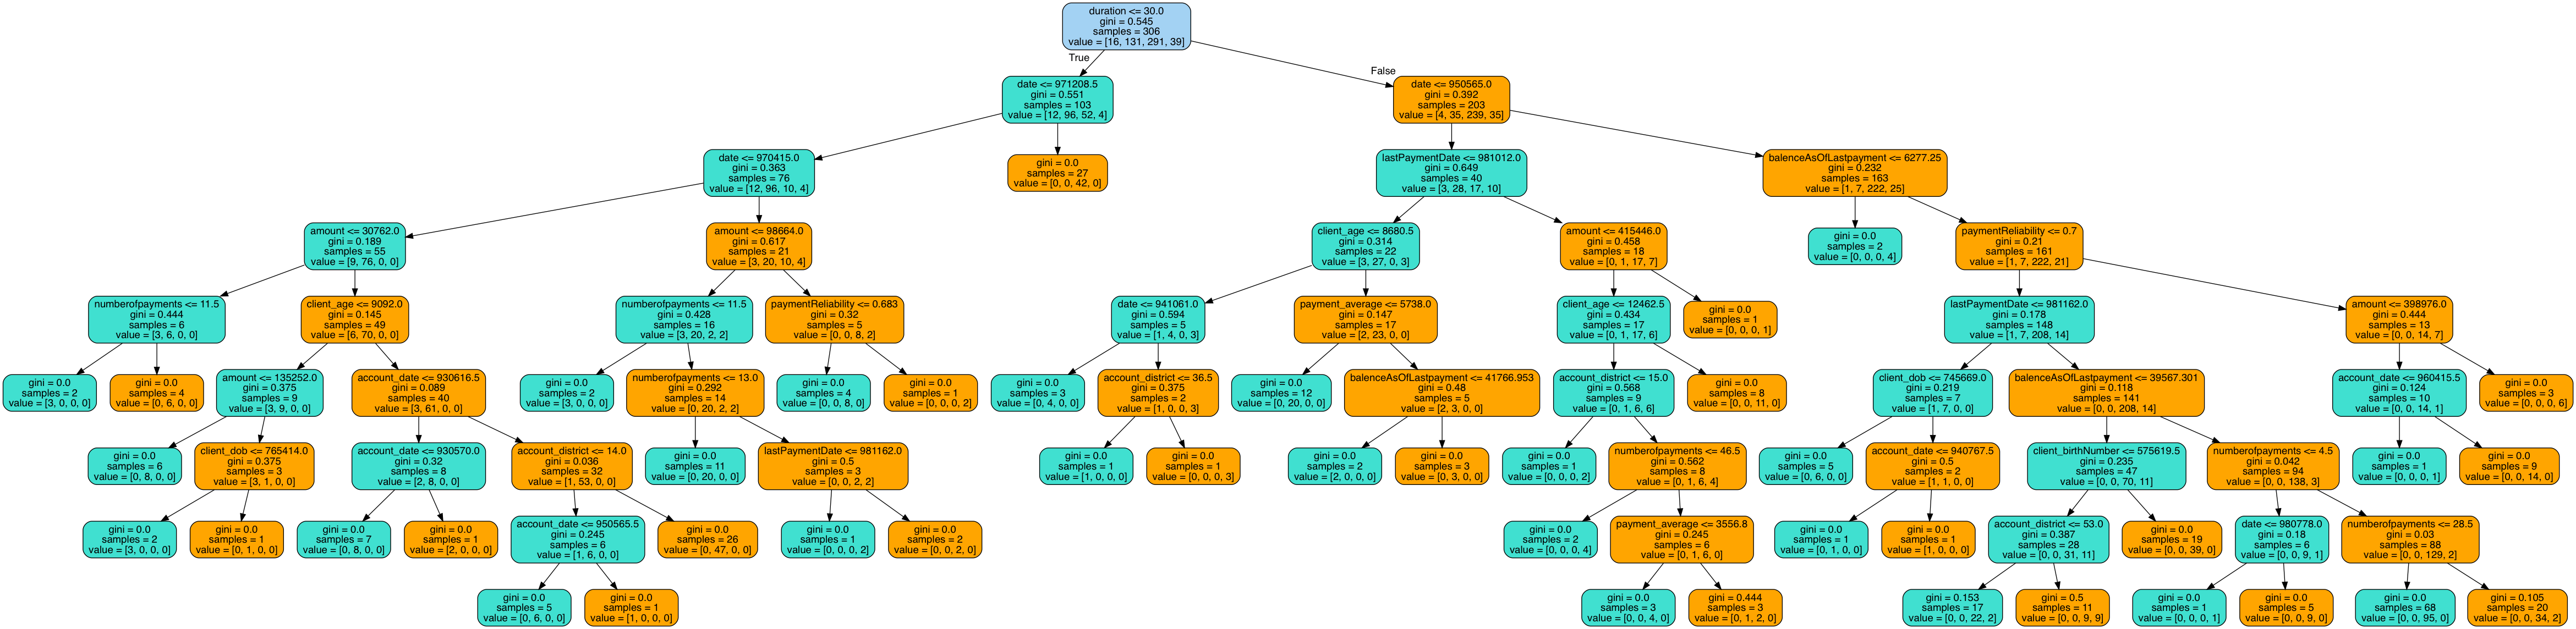

In [44]:
from IPython.display import Image
Image(gettreeImg(clf.estimators_[5],cols).create_png())

In [45]:
clf = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=0)
clf.fit(X_train_bin,y_train_bin)
y_pred_bin = clf.predict(X_test_bin)
print('Accuracy',accuracy_score(y_test_bin,y_pred_bin)*100)

Accuracy 94.14634146341463


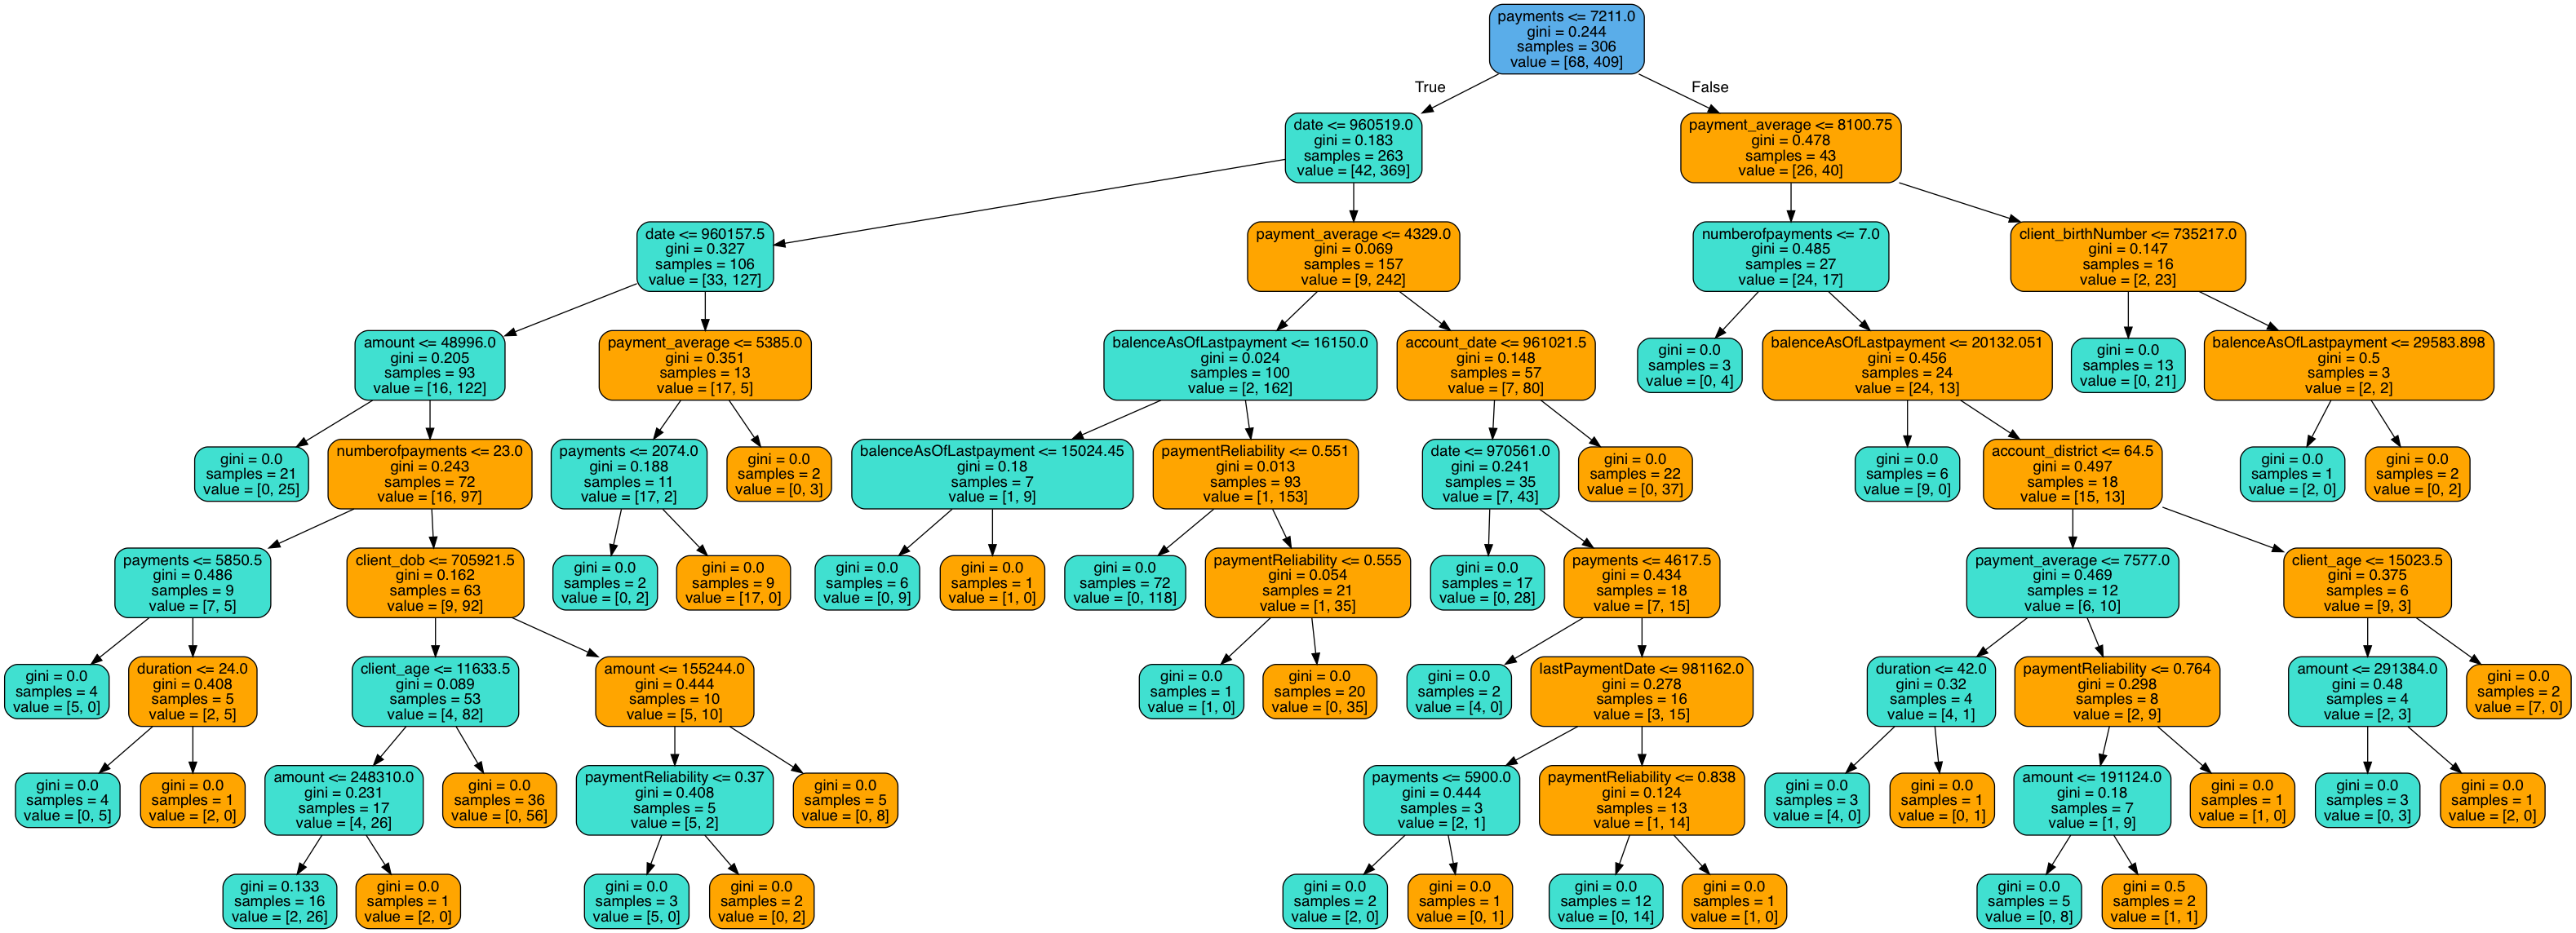

In [46]:
from IPython.display import Image
Image(gettreeImg(clf.estimators_[5],cols).create_png())

#### 6.6.2 Interpretation

On using Random forest for predicting the same status feature for multiclass classifier the accuracy is increased to 94%. It is evident that the random forest has performed better since multiple decision trees are used and then the results are computed based on voting system.

### 6.7 NAIVE BAYES 

#### Naive Bayes Classifier on "status" feature and training data for multiclass classification


Applying Naive Bayes classifier on "status" feature and training data for multiclass classification. Calculated accuracy of the predicted data(y_test, y_pred)

In [47]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB().fit(X_train, y_train)  

y_pred = model.predict(X_test)

#### 6.7.1 Metrics

In [48]:
print('Accuracy',accuracy_score(y_test,y_pred)*100)

Accuracy 87.8048780487805


In [49]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))  

[[  2   6   0   0]
 [  3  50   0   8]
 [  0   0 125   0]
 [  0   0   8   3]]


#### NAIVE BAYES on "status" feature and training data for binary classification

Applying Naive Bayes classifier on "status" feature and training data for binary classification. After making 'status' feature as binary, the precision increased from 84.88% to 91.71% meaning the model is now able to clearly distinguish between clients paying loan regularly and not paying.

In [50]:
from sklearn.naive_bayes import GaussianNB

binay_model = GaussianNB().fit(X_train_bin, y_train_bin)  

y_pred_bin = binay_model.predict(X_test_bin)



#### 6.7.3 Metrics

In [51]:
print('Accuracy',accuracy_score(y_test_bin,y_pred_bin)*100)

Accuracy 90.2439024390244


In [52]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_bin, y_pred_bin)) 

[[  4   9]
 [ 11 181]]


#### 6.7.4 Interpretation

The accuracy of predicting the "status" feature incase of Decision tree for multiclass classifier was 84.3%. Now, on using Naive Bayes for predicting the same feature for multiclass classifier, the accuracy is increased to 84.88%. Also, incase of Decision tree for binary classifier, it was 86.34% and on using Naive Bayes for predicting the same feature for binary classifier, it has increased to 91.71%. It is evident that the Naive Bayes Classifier has performed better in our business case.

### 6.8 K-Nearest Neighbor (KNN)

#### Applying KNN on "status" feature and training data for multiclass classification.

In [53]:
from sklearn.neighbors import KNeighborsClassifier 

model = KNeighborsClassifier(n_neighbors=4)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)



#### 6.8.1 Metrics

In [54]:
print('Accuracy',accuracy_score(y_test,y_pred)*100)

Accuracy 68.78048780487805


In [55]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred)) 

[[ 0  4  3  1]
 [ 3 45 13  0]
 [ 4 25 96  0]
 [ 0  1 10  0]]


#### K-Nearset Neighbor on "status" feature and training data for binary classification

In [56]:
from sklearn.neighbors import KNeighborsClassifier 

binay_model = KNeighborsClassifier(n_neighbors=4).fit(X_train_bin, y_train_bin)  

y_pred_bin = binay_model.predict(X_test_bin)



#### 6.8.2 Metrics

In [57]:
print('Accuracy',accuracy_score(y_test_bin,y_pred_bin)*100)

Accuracy 86.34146341463415


In [58]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_bin, y_pred_bin)) 

[[  1  12]
 [ 16 176]]


####  6.8.3 Interpretation
After making 'status' feature as binary, the precision increased from 72.68% to 86.34% meaning the model is now able to clearly distinguish between clients paying loan regularly and not paying.

### 6.9 Support Vector Machine (SVM)

#### Applying SVM classifier on "status" feature and training data for multiclass classification. 

In [ ]:
from sklearn.svm import SVC 

svclassifier = SVC(kernel='linear')  
model= svclassifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### 6.9.1 Metrics

In [ ]:
print('Accuracy',accuracy_score(y_test,y_pred)*100)

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred)) 

#### SVM on "status" feature and training data for binary classification

In [ ]:
svclassifier = SVC(kernel='linear')  
binary_model= svclassifier.fit(X_train_bin, y_train_bin)
y_pred_bin = binary_model.predict(X_test_bin)

#### 6.9.2 Metrics

In [ ]:
print('Accuracy',accuracy_score(y_test_bin,y_pred_bin)*100)

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred_bin)) 

#### 6.9.3  Interpretation
After making 'status' feature as binary, the precision increased from 87.31% to 93.65% meaning the model is now able to clearly distinguish between clients paying loan regularly and not paying.

#### Consolidation of Classification Algorithms with Accuracy

<table align=left>
<tr>
<th>Machine Learning Model</th>
<th>Accuracy</th>
<tr>
    <tr>
<td>Linear Regression R2 Value</td>
<td>0.88</td>
</tr>
    <tr>
<td>Logistic Regression</td>
<td>94%</td>
</tr>
    <tr>
<td>Decision Tree</td>
<td>92.6%</td>
</tr>
    <tr>
<td>Random Forest</td>
<td>94.14%</td>
</tr>
    <tr>
<td>Naive Byes</td>
<td>90.24%</td>
</tr>
    <tr>
<td>K-nearest Neighbour</td>
<td>86.3%</td>
</tr>
    <tr>
<td>SVM</td>
<td>93.65%</td>
</tr>
</table>

## 6.10 Conclusion

Inference from Classification models
In this section, we performed multi class classification and binary classification. In multi class classification, we are trying to understand if a customer is going to default on a loan , or has already defaulted on a loan. Based on this information, we can understand the customers credit card payment credibality and accordingly offer different promotions.

The binary classification only indicates likelihood of a customers defaulting, irrespective of current loan or completed loans. This will help us understand the customers ability to payback loans and to be approved for future loans.

Along with credit card data we were able to gather data regarding customes and their loan info. The loan data and other customers information helps us profile them and understand their spending and repayment ability. And this will further extend our use case to understand the credit card payment reliability and to provide appropriate promotions for such customers. 

To reiterate, our business use case was to profile customers and understand their ability to payback current loans and their credit card balances  to target them for future loan and credit promotions. It is very important to identify defaulters, as it is to identify good customers. Another key requirement for this dataset is to identify defaulters pattern to judge new customers.

We were able to perform clustering to understand multiple groups of similar pattern in our dataset using clustering techniques. We also worked on regression to predict contineous numeric values(loan amount) and classification to understand if the person defaulted a loan that was offered to him.

Key conclusions about our dataset - the dataset has many independent features related to a customer, from other datasets, which could be used inorder to gain more information, but some references(feature explaination) to these information are missing. For example, the date when the assesment was done is missing, which is a vital in describing the reference point for all date related information.
									
The dataset has more linear features, than nonlinear features.(For example, age is a non linear feature, as it  has no mathamatical relation to the loan amount being differed). Hence our logistic regression method works better than other classificaiton algorithms.

Running all these algorithms on the loan dataset from Czech bank, 
1. we could predict the loan amount using linear regression
2. we could predict what is the probabality that the customer would default or not using classification. Based on the accuracy score, Random Forest and Logistic Regression are performing well in this case.
3. Based on the above techniques we could identify payment reliability of the prospective customers.
4. Also, we can target specific customers for various promotions based on these predictions.

## 6.11 Link to Github
https://github.com/nidhijmr/CMPE257-Machine-Learning


## 6.12 Progress in Slack and Allocation of responsibilities in the team

#### Progress on slack

Regularly updated on slack on channel <b>seekers</b>

#### Allocation of responsibilities in the team



* Identify business use case and dataset: Entire Team
* Data preprocessing, Data Enrichment - Anuradha Rajashekar (012409956), Sindhu Goudru Shivanandappa (010823683)
* KMeans, GMM - Anuradha Rajashekar(012409956)
* Linear Regression & Latent Manifold, PCA - Ashwini Shankar Narayan(012506910)
* Naive Bayes, Decision Tree, Random Forest - Nidhi Jamar(010070593)
* Logistic Regession, KNN, SVM - Sindhu Goudru Shivanandappa Patil(010823683)
* Conclusion: Entire Team